In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os
import string
import re
import pickle
from pickle import dump
import unicodedata
from unicodedata import normalize
import random

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 15 23:13:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset preprocessing

### Europarl dataset

In [5]:
# load doc into memory
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text
 
# split a loaded document into sentences
def to_sentences(doc):
	return doc.strip().split('\n')
 
# clean a list of lines
def clean_lines(lines):
	cleaned = list()
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	table = str.maketrans('', '', string.punctuation)
	for line in lines:

		line = normalize('NFD', line).encode('ascii', 'ignore')
		line = line.decode('UTF-8')

		line = line.split()

		line = [word.lower() for word in line]

		line = [word.translate(table) for word in line]

		line = [re_print.sub('', w) for w in line]

		line = [word for word in line if word.isalpha()]
		line = ' '.join(line)
		line = '<start> ' + line + ' <end>'
		# store as string
		cleaned.append(line)
	return cleaned
 
# save a list of clean sentences to file
def save_clean_sentences(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

def load_datasets(filename):
    return pickle.load(open(filename, 'rb'))

def produce_train_test(en, fr, ratio = 0.9, total_size = 5000):
    n_train = int(total_size * ratio)
    indexes = random.sample(range(total_size), n_train)
    trainX =  en[indexes]
    trainY = fr[indexes]

    testX = en[[i for i in range(total_size) if i not in indexes]]
    testY = fr[[i for i in range(total_size) if i not in indexes]]
    return trainX, trainY, testX, testY

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer(filters = '')
	tokenizer.fit_on_texts(lines)
	return tokenizer


# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	X = tokenizer.texts_to_sequences(lines)
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 

In [ ]:
# load English data
filename = 'europarl-v7.fr-en.en'
doc = load_doc(filename)
en_sentences = to_sentences(doc)
en_sentences = clean_lines(en_sentences)
 
# load French data
filename = 'europarl-v7.fr-en.fr'
doc = load_doc(filename)
fr_sentences = to_sentences(doc)
fr_sentences = clean_lines(fr_sentences)

In [ ]:
# save cleaned dataset
save_clean_sentences(en_sentences, 'english.pkl')
save_clean_sentences(fr_sentences, 'french.pkl')

Saved: english.pkl
Saved: french.pkl


In [ ]:
# load cleaned data to generate datasets
en_sentences = load_datasets('english.pkl')
fr_sentences = load_datasets('french.pkl')

In [ ]:
total_size = 5000
en = np.array(en_sentences[:total_size])
fr = np.array(fr_sentences[:total_size])

In [ ]:
trainX, trainY, testX, testY = produce_train_test(en, fr)

### manythings dataset

In [65]:
def preprocess_sentence(line):

    re_print = re.compile('[^%s]' % re.escape(string.printable))

    table = str.maketrans('', '', string.punctuation)

    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')

    line = line.split()

    line = [word.lower() for word in line]

    line = [word.translate(table) for word in line]

    line = [re_print.sub('', w) for w in line]

    line = [word for word in line if word.isalpha()]
    line = ' '.join(line)
    line = '<start> ' + line + ' <end>'
    return line
    
import io

# Create the Dataset
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t', 2)[:-1]]  for l in lines[:num_examples]]
    return zip(*word_pairs)


In [66]:
!unzip 'fra-eng.zip'

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [68]:
path_to_file = "fra.txt"

In [69]:
en, fr = create_dataset(path_to_file, None)
trainX, trainY, testX, testY = produce_train_test(np.array(en[:50000]), np.array(fr[:50000]), total_size = 50000)

### Create tokenizer 

In [72]:
en_tokenizer = create_tokenizer(en)
en_vocab_size = len(en_tokenizer.word_index) + 1
en_length = max_length(en)
print('English Vocabulary Size: %d' % en_vocab_size)
print('English Max Length: %d' % (en_length))

fr_tokenizer = create_tokenizer(fr)
fr_vocab_size = len(fr_tokenizer.word_index) + 1
fr_length = max_length(fr)
print('French Vocabulary Size: %d' % fr_vocab_size)
print('French Max Length: %d' % (fr_length))
 
# prepare training data
trainX = encode_sequences(en_tokenizer, en_length, trainX)
trainY = encode_sequences(fr_tokenizer, fr_length, trainY)

# prepare validation data
testX = encode_sequences(en_tokenizer, en_length, testX)
testY = encode_sequences(en_tokenizer, fr_length, testY)

English Vocabulary Size: 15826
English Max Length: 49
French Vocabulary Size: 30186
French Max Length: 57


In [73]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((45000, 49), (45000, 57), (5000, 49), (5000, 57))

In [74]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      
print ("Input Language; index to word mapping")
convert(en_tokenizer, trainX[0])
print ()
print ("Target Language; index to word mapping")
convert(fr_tokenizer, trainY[0])

Input Language; index to word mapping
1 ----> <start>
3 ----> i
33 ----> like
244 ----> being
35 ----> with
4 ----> you
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
198 ----> jaime
57 ----> etre
21 ----> en
55 ----> votre
1429 ----> compagnie
2 ----> <end>


# Model Parameters

In [75]:
BUFFER_SIZE = len(trainX)
BATCH_SIZE = 64
steps_per_epoch = len(trainY)//BATCH_SIZE
embedding_dim = 256
units = 1024
architecture = 'gru' # gru, rnn

In [76]:
dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [77]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 49]), TensorShape([64, 57]))

# Encoder class

In [78]:
# Encoder class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # Embed the vocab to a dense embedding 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # GRU Layer
        # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
        # used for the linear transformation of the recurrent state
        if architecture == 'gru':
            self.rnn = tf.keras.layers.GRU(self.enc_units,
                                            return_sequences=True,
                                            return_state=True,
                                            recurrent_initializer='glorot_uniform')
        if architecture == 'rnn':
            self.rnn = tf.keras.layers.SimpleRNN(self.enc_units,
                                            return_sequences=True,
                                            return_state=True,
                                            recurrent_initializer='glorot_uniform')     

    # Encoder network comprises an Embedding layer followed by a GRU layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.rnn(x, initial_state=hidden)
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [79]:
encoder = Encoder(en_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 49, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


# Attention layer

In [80]:
# Attention Mechanism
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [81]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 49, 1)


# Decoder Class

In [82]:
# Decoder class
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.SimpleRNN(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Used for attention
    self.attention = Attention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x shape == (batch_size, 1)
    # hidden shape == (batch_size, max_length)
    # enc_output shape == (batch_size, max_length, hidden_size)

    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_length, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [83]:
decoder = Decoder(fr_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 30186)


# Training

In [84]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [85]:
import os

checkpoint_dir = './rnn_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([fr_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import time

EPOCHS = 30
history = []
# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  history.append(total_loss / steps_per_epoch)
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.9247
Epoch 1 Batch 100 Loss 0.5738
Epoch 1 Batch 200 Loss 0.5589
Epoch 1 Batch 300 Loss 0.5465
Epoch 1 Batch 400 Loss 0.5652
Epoch 1 Batch 500 Loss 0.5834
Epoch 1 Batch 600 Loss 0.5513
Epoch 1 Batch 700 Loss 0.5525
Epoch 1 Loss 0.5681
Time taken for 1 epoch 509.09537863731384 sec

Epoch 2 Batch 0 Loss 0.5590
Epoch 2 Batch 100 Loss 0.5653
Epoch 2 Batch 200 Loss 0.5756
Epoch 2 Batch 300 Loss 0.5537
Epoch 2 Batch 400 Loss 0.5689
Epoch 2 Batch 500 Loss 0.5505
Epoch 2 Batch 600 Loss 0.5672
Epoch 2 Batch 700 Loss 0.5606
Epoch 2 Loss 0.5616
Time taken for 1 epoch 475.45911502838135 sec

Epoch 3 Batch 0 Loss 0.5514
Epoch 3 Batch 100 Loss 0.5681
Epoch 3 Batch 200 Loss 0.6006
Epoch 3 Batch 300 Loss 0.5734
Epoch 3 Batch 400 Loss 0.5553
Epoch 3 Batch 500 Loss 0.5551
Epoch 3 Batch 600 Loss 0.5522
Epoch 3 Batch 700 Loss 0.5943
Epoch 3 Loss 0.5631
Time taken for 1 epoch 473.88068771362305 sec

Epoch 4 Batch 0 Loss 0.5538
Epoch 4 Batch 100 Loss 0.5667
Epoch 4 Batch 200 Loss 0.56

# Evaluation

In [ ]:
def plot_training(history):
    loss = history
    epochs = range(1, len(history) + 1)
    
    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label = 'training loss')
    plt.title('training loss')
    plt.legend()


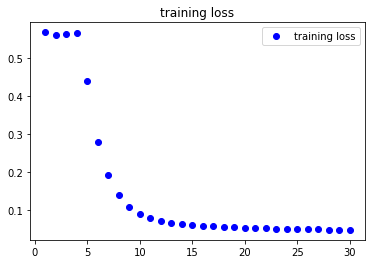

In [ ]:
plot_training(history)

In [86]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence, max_length_inp, max_length_targ, inp_lang, targ_lang):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = tf.zeros((1, units))
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [87]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [88]:
# Translate function (which internally calls the evaluate function)
def translate(sentence, max_length_inp, max_length_targ, inp_lang, targ_lang):
  result, sentence, attention_plot = evaluate(sentence, max_length_inp, max_length_targ, inp_lang, targ_lang)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [89]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> dont stand in my way <end>
Predicted translation: ne te mets pas dans mon chemin <end> 


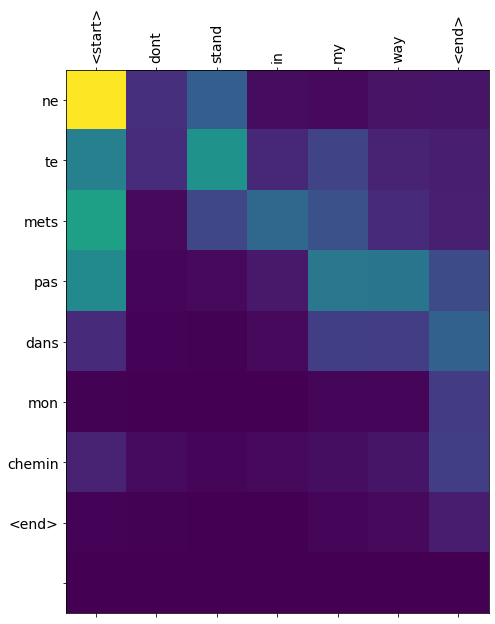

In [94]:
sentence = 'dont stand in my way'
translate(sentence, trainX.shape[1], trainY.shape[1], en_tokenizer, fr_tokenizer)

### Bleu score

In [91]:
from nltk.translate.bleu_score import corpus_bleu

def code_to_text(sentence, tokenizer):
    result = ''
    for j in sentence:
        if j != 2 and j != 1:
            result += tokenizer.index_word[j] + ' '
        if j == 2:
            break
    return result

def evaluate_model(testX, testY, max_length_inp, max_length_targ, inp_lang, targ_lang):
    actual, predicted = [], []
    bleu = 0
    for i, sentence in enumerate(testX):
        
        # convert encoded source back to text
        og_sentence = code_to_text(sentence, inp_lang)
        translation = code_to_text(testY[i], targ_lang)
        # translate to target lang
        result, sentence, attention_plot = evaluate(og_sentence, max_length_inp, max_length_targ, inp_lang, targ_lang)
        if i < 20:
            print('src=[%s], target=[%s], predicted=[%s]\n' % (og_sentence, translation, result))
        actual.append([translation.split()])
        predicted.append(result.split()[:-1])

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.0, 1, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 1, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0, 0, 0, 1)))

In [95]:
evaluate_model(trainX[:5000], trainY[:5000], testX.shape[1], testY.shape[1], en_tokenizer, fr_tokenizer)

src=[i like being with you ], target=[jaime etre en votre compagnie ], predicted=[jaime etre en ta compagnie <end> ]

src=[thanks again ], target=[encore une fois merci ], predicted=[encore une fois merci <end> ]

src=[is something wrong ], target=[quelque chose ne va pas ], predicted=[quelque chose ne va pas <end> ]

src=[get us out of here ], target=[sorteznous dici ], predicted=[sorteznous dici <end> ]

src=[get to the point ], target=[viensen au fait ], predicted=[viensen au fait <end> ]

src=[tom botched the job ], target=[tom a bacle le travail ], predicted=[tom a bacle le travail <end> ]

src=[we realize that ], target=[nous en sommes conscients ], predicted=[nous en sommes conscients <end> ]

src=[thats a big deal ], target=[cest une grosse affaire ], predicted=[cest une grosse affaire <end> ]

src=[come downtown with us ], target=[venez en ville avec nous ], predicted=[venez en ville avec nous <end> ]

src=[are you a christian ], target=[etesvous chretien ], predicted=[etesvou

In [ ]:
code_to_text(testY[2], fr_tokenizer)

'<start> <end>'

In [ ]:
testY.shape

(5000, 57)

In [ ]:
testY[1]

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)